In [48]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.figure_factory import create_table

from sklearn.linear_model import RidgeCV, Lasso, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [49]:
from utils.helper import get_news_scores, add_indicators, trim_df_columns, reg_model_metrics


### Data Preparation

In [50]:
df_stocks = pd.read_csv('data/jpm_bars_2024-02-20.csv')

In [51]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)

In [52]:
df_stocks.tail()

open      high      low   close     volume  trade_count  \
date                                                                    
2024-02-12  174.78  176.8080  173.700  175.79  8539316.0      99614.0   
2024-02-13  175.32  176.2299  172.615  174.26  8397631.0     119866.0   
2024-02-14  175.07  176.1000  174.420  176.03  7056664.0      92056.0   
2024-02-15  176.15  180.2100  176.150  179.87  8723390.0     120899.0   
2024-02-16  179.61  179.9800  178.160  179.03  8292848.0      99541.0   

                  vwap  
date                    
2024-02-12  175.753564  
2024-02-13  174.170059  
2024-02-14  175.386226  
2024-02-15  179.302307  
2024-02-16  178.978772

### Engineering Features

In [53]:
#Add Indicators to stock dataframe
df_stocks_full = add_indicators(df_stocks)

LWMA
VIDYA
ALMA
MAMA
SWI
VORTEX


In [54]:
df_stocks_full.head()

open     high    low  close      volume  trade_count       vwap  \
2016-01-25  56.48  56.8500  55.60  55.66  22118832.0     139637.0  56.137613   
2016-01-26  55.85  57.1500  55.81  57.08  19392731.0     107516.0  56.810083   
2016-01-27  57.10  58.2699  56.56  57.04  21426316.0     141369.0  57.319320   
2016-01-28  57.52  57.9700  56.63  57.28  16677125.0     109380.0  57.280159   
2016-01-29  57.86  59.5400  57.51  59.50  32348693.0     140585.0  58.803356   

            SMA_41_period_SMA  SMM_9_period_SMM  SSMA_9_period_SSMA  ...  \
2016-01-25                NaN             57.01           57.533632  ...   
2016-01-26                NaN             57.01           57.474201  ...   
2016-01-27                NaN             57.01           57.418425  ...   
2016-01-28                NaN             57.01           57.400947  ...   
2016-01-29                NaN             57.01           57.662028  ...   

            APZ_LOWER  SQZMI_20_period_SQZMI       VPT_VPT  FVE_0  VFI_VFI  \
2016-01-25  52.716388                  False -1.721438e+08    NaN      NaN   
2016-01-26  52.815668                  False -1.365423e+08    NaN      NaN   
2016-01-27  52.893844                  False -1.380459e+08    NaN      NaN   
2016-01-28  53.022397                  False -1.440198e+08    NaN      NaN   
2016-01-29  53.580934                  False -9.175200e+07    NaN      NaN   

            MSD_MSD  STC_10_period_STC  EVSTC_10_period_EVSTC  \
2016-01-25      NaN           0.359068                    NaN   
2016-01-26      NaN           1.254117                  100.0   
2016-01-27      NaN           3.440120                  100.0   
2016-01-28      NaN           8.567260                  100.0   
2016-01-29      NaN          21.558689                  100.0   

            WILLIAMS_FRACTAL_BearishFractal  WILLIAMS_FRACTAL_BullishFractal  
2016-01-25                              0.0                              0.0  
2016-01-26                              0.0                              0.0  
2016-01-27                              0.0                              0.0  
2016-01-28                              0.0                              0.0  
2016-01-29                              0.0                              0.0  

[5 rows x 132 columns]

In [55]:
# Dropping columns with NaN values
df_stocks_full = trim_df_columns(df_stocks_full)

In [56]:
df_stocks_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2031 entries, 2016-01-25 to 2024-02-16
Data columns (total 95 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   open                                2031 non-null   float64
 1   high                                2031 non-null   float64
 2   low                                 2031 non-null   float64
 3   close                               2031 non-null   float64
 4   volume                              2031 non-null   float64
 5   trade_count                         2031 non-null   float64
 6   vwap                                2031 non-null   float64
 7   SMM_9_period_SMM                    2031 non-null   float64
 8   SSMA_9_period_SSMA                  2031 non-null   float64
 9   EMA_9_period_EMA                    2031 non-null   float64
 10  DEMA_9_period_DEMA                  2031 non-null   float64
 11  TEMA_9_period_TEMA               

In [57]:
df_news = pd.read_csv('data/jpm_news_2024-02-20.csv')

In [58]:
df_news.drop(['Unnamed: 0', 'updated_at'], axis=1, inplace=True)
df_news['created_at'] = df_news.created_at.apply(lambda x: x.split(' ')[0])
df_news.rename(columns={'created_at': 'date'}, inplace=True)
df_news = df_news.sort_values('date', ascending=True)
df_news.set_index('date', inplace=True)

In [59]:
df_news.head()

headline summary  \
date                                                                    
2015-01-02  JP Morgan Chase Reports Adjustment to Warrant ...     NaN   
2015-01-05  CNBC Now Tweets: 'BREAKING: Morgan Stanley fir...     NaN   
2015-01-06  Option Alert: JP Morgan Feb $60 Call; 64,626 C...     NaN   
2015-01-06                        Should We Fear A Rate Hike?     NaN   
2015-01-06  JPMorgan Chase Breakup Rumors Start Again As B...     NaN   

                                              url news_type     score  \
date                                                                    
2015-01-02  https://www.benzinga.com/node/5116220  NEGATIVE  0.998391   
2015-01-05  https://www.benzinga.com/node/5119277  NEGATIVE  0.997791   
2015-01-06  https://www.benzinga.com/node/5124585  NEGATIVE  0.988306   
2015-01-06  https://www.benzinga.com/node/5117745  NEGATIVE  0.997089   
2015-01-06  https://www.benzinga.com/node/5124086  NEGATIVE  0.983724   

                                          symbols  
date                                               
2015-01-02                                ['JPM']  
2015-01-05                                ['JPM']  
2015-01-06                                ['JPM']  
2015-01-06                                ['JPM']  
2015-01-06  ['BAC', 'C', 'DB', 'GS', 'JPM', 'MS']

In [60]:
# Getting the news scores regarding the stock
df_score = get_news_scores(df = df_news)

In [61]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1732 entries, 2015-01-02 to 2024-02-14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1732 non-null   float64
 1   news_type  1732 non-null   object 
dtypes: float64(1), object(1)
memory usage: 40.6+ KB


In [62]:
# Adding news scores to stock dataframe
df = pd.concat([df_stocks_full,df_score], axis=1)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2364 entries, 2016-01-25 to 2024-02-11
Data columns (total 97 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   open                                2031 non-null   float64
 1   high                                2031 non-null   float64
 2   low                                 2031 non-null   float64
 3   close                               2031 non-null   float64
 4   volume                              2031 non-null   float64
 5   trade_count                         2031 non-null   float64
 6   vwap                                2031 non-null   float64
 7   SMM_9_period_SMM                    2031 non-null   float64
 8   SSMA_9_period_SSMA                  2031 non-null   float64
 9   EMA_9_period_EMA                    2031 non-null   float64
 10  DEMA_9_period_DEMA                  2031 non-null   float64
 11  TEMA_9_period_TEMA               

In [64]:
df.dropna(inplace=True)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1399 entries, 2016-01-25 to 2024-02-14
Data columns (total 97 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   open                                1399 non-null   float64
 1   high                                1399 non-null   float64
 2   low                                 1399 non-null   float64
 3   close                               1399 non-null   float64
 4   volume                              1399 non-null   float64
 5   trade_count                         1399 non-null   float64
 6   vwap                                1399 non-null   float64
 7   SMM_9_period_SMM                    1399 non-null   float64
 8   SSMA_9_period_SSMA                  1399 non-null   float64
 9   EMA_9_period_EMA                    1399 non-null   float64
 10  DEMA_9_period_DEMA                  1399 non-null   float64
 11  TEMA_9_period_TEMA               

In [66]:
#converting the news_type feature to binary type, POSITIVE = 1 and NEGATIVE = 0 
df['news_type'] = df['news_type'].apply(lambda x:1 if x in ['POSITIVE'] else 0)

In [67]:
df.head()

open   high    low  close      volume  trade_count       vwap  \
2016-01-25  56.48  56.85  55.60  55.66  22118832.0     139637.0  56.137613   
2016-01-26  55.85  57.15  55.81  57.08  19392731.0     107516.0  56.810083   
2016-01-28  57.52  57.97  56.63  57.28  16677125.0     109380.0  57.280159   
2016-02-01  59.16  59.65  58.44  58.86  17857599.0     113520.0  58.885386   
2016-02-02  57.88  57.98  56.75  57.03  24152125.0     137045.0  57.134165   

            SMM_9_period_SMM  SSMA_9_period_SSMA  EMA_9_period_EMA  ...  \
2016-01-25             57.01           57.533632         56.847037  ...   
2016-01-26             57.01           57.474201         56.894979  ...   
2016-01-28             57.01           57.400947         56.997025  ...   
2016-02-01             57.04           57.809081         57.779113  ...   
2016-02-02             57.04           57.714548         57.627896  ...   

             WTO_WT1.   WTO_WT2.  FISH_10_period_FISH.  ICHIMOKU_TENKAN  \
2016-01-25 -70.824997 -77.019343             -2.071812         57.16750   
2016-01-26 -64.631547 -72.564631             -1.666978         57.16750   
2016-01-28 -47.810715 -59.712076             -0.593944         56.46495   
2016-02-01 -19.619412 -38.729085              0.607130         57.15500   
2016-02-02 -20.544374 -29.969918              0.704860         57.35500   

            APZ_UPPER  APZ_LOWER       VPT_VPT  STC_10_period_STC     score  \
2016-01-25  58.767575  52.716388 -1.721438e+08           0.359068  0.966308   
2016-01-26  58.847079  52.815668 -1.365423e+08           1.254117  0.928192   
2016-01-28  59.037229  53.022397 -1.440198e+08           8.567260  0.999341   
2016-02-01  59.957532  53.928361 -1.006070e+08          42.540720  0.819788   
2016-02-02  59.880420  53.864544 -1.339880e+08          68.251240  0.997212   

            news_type  
2016-01-25          1  
2016-01-26          0  
2016-01-28          1  
2016-02-01          1  
2016-02-02          0  

[5 rows x 97 columns]

In [68]:
df.describe()

open         high          low        close        volume  \
count  1399.000000  1399.000000  1399.000000  1399.000000  1.399000e+03   
mean    118.862782   120.031664   117.727861   118.881237  1.583948e+07   
std      29.303266    29.512926    29.105049    29.327735  7.818385e+06   
min      53.910000    53.910000    52.500000    53.070000  1.604000e+05   
25%      98.670000    99.900000    97.120000    98.245000  1.082127e+07   
50%     116.050000   117.180000   114.980000   115.850000  1.414673e+07   
75%     141.755000   143.325000   140.225000   141.920000  1.817264e+07   
max     176.200000   178.300000   174.420000   176.270000  7.290765e+07   

         trade_count         vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
count    1399.000000  1399.000000       1399.000000         1399.000000   
mean   119827.245890   118.880825        118.687169          118.452794   
std     55583.411866    29.320290         29.279979           28.995559   
min         1.000000    53.284123         57.010000           56.749482   
25%     83741.500000    98.494076         98.280000           99.021029   
50%    107609.000000   116.111837        115.550000          115.305490   
75%    138244.000000   142.082344        141.455000          140.970511   
max    457367.000000   175.830884        175.010000          173.865030   

       EMA_9_period_EMA  ...     WTO_WT1.     WTO_WT2.  FISH_10_period_FISH.  \
count       1399.000000  ...  1399.000000  1399.000000           1399.000000   
mean         118.662099  ...     9.496383     9.211454              0.469732   
std           29.150924  ...    36.056873    35.471344              1.828166   
min           56.131166  ...   -75.865062   -77.019343             -4.937305   
25%           98.601924  ...   -20.169885   -19.933625             -0.830065   
50%          115.559896  ...    12.859893    12.098080              0.428172   
75%          141.334766  ...    40.701072    40.427148              1.740069   
max          174.879221  ...    81.244741    79.325133              6.302216   

       ICHIMOKU_TENKAN    APZ_UPPER    APZ_LOWER       VPT_VPT  \
count      1399.000000  1399.000000  1399.000000  1.399000e+03   
mean        118.586794   123.348730   114.333714  2.071455e+08   
std          29.170761    30.223357    28.737519  3.726057e+08   
min          55.820000    58.767575    52.659098 -3.914145e+08   
25%          98.656250   103.265886    94.343337 -1.097987e+08   
50%         115.385000   120.529946   112.072698  1.140565e+08   
75%         141.115325   146.896528   136.914213  5.816725e+08   
max         174.865000   181.176266   171.446342  9.704963e+08   

       STC_10_period_STC        score    news_type  
count        1399.000000  1399.000000  1399.000000  
mean           51.366757     0.928611     0.572552  
std            43.591354     0.108196     0.494885  
min             0.000000     0.502791     0.000000  
25%             1.236667     0.913440     0.000000  
50%            54.932751     0.976181     1.000000  
75%            99.549454     0.993851     1.000000  
max           100.000000     0.999861     1.000000  

[8 rows x 97 columns]

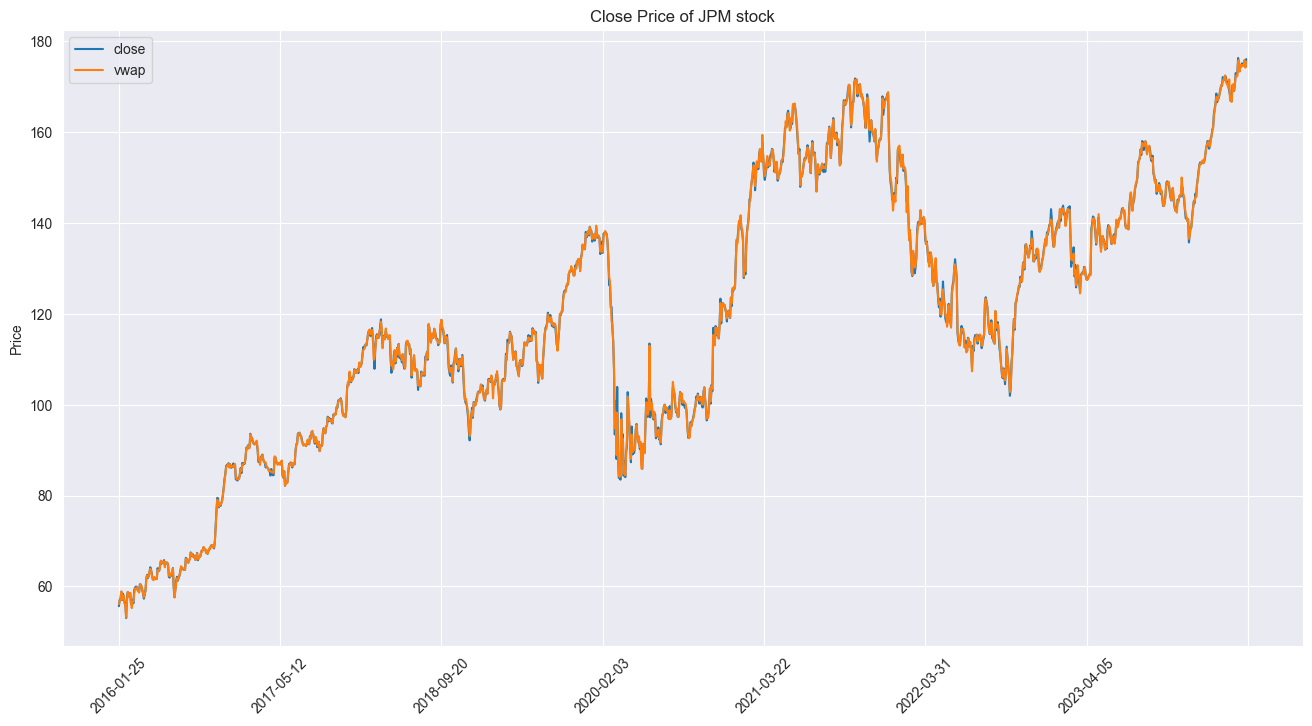

In [69]:
plt.figure(figsize=(16,8))
df['close'].plot(kind='line')
df['vwap'].plot(kind='line')
plt.xticks(rotation = 45)
plt.title('Close Price of JPM stock')
plt.ylabel('Price')
plt.legend()
plt.show()


##### The 'vwap' is a feature variable which is an independent, and 'close' price is the target, which is a dependent variable (explainable).  

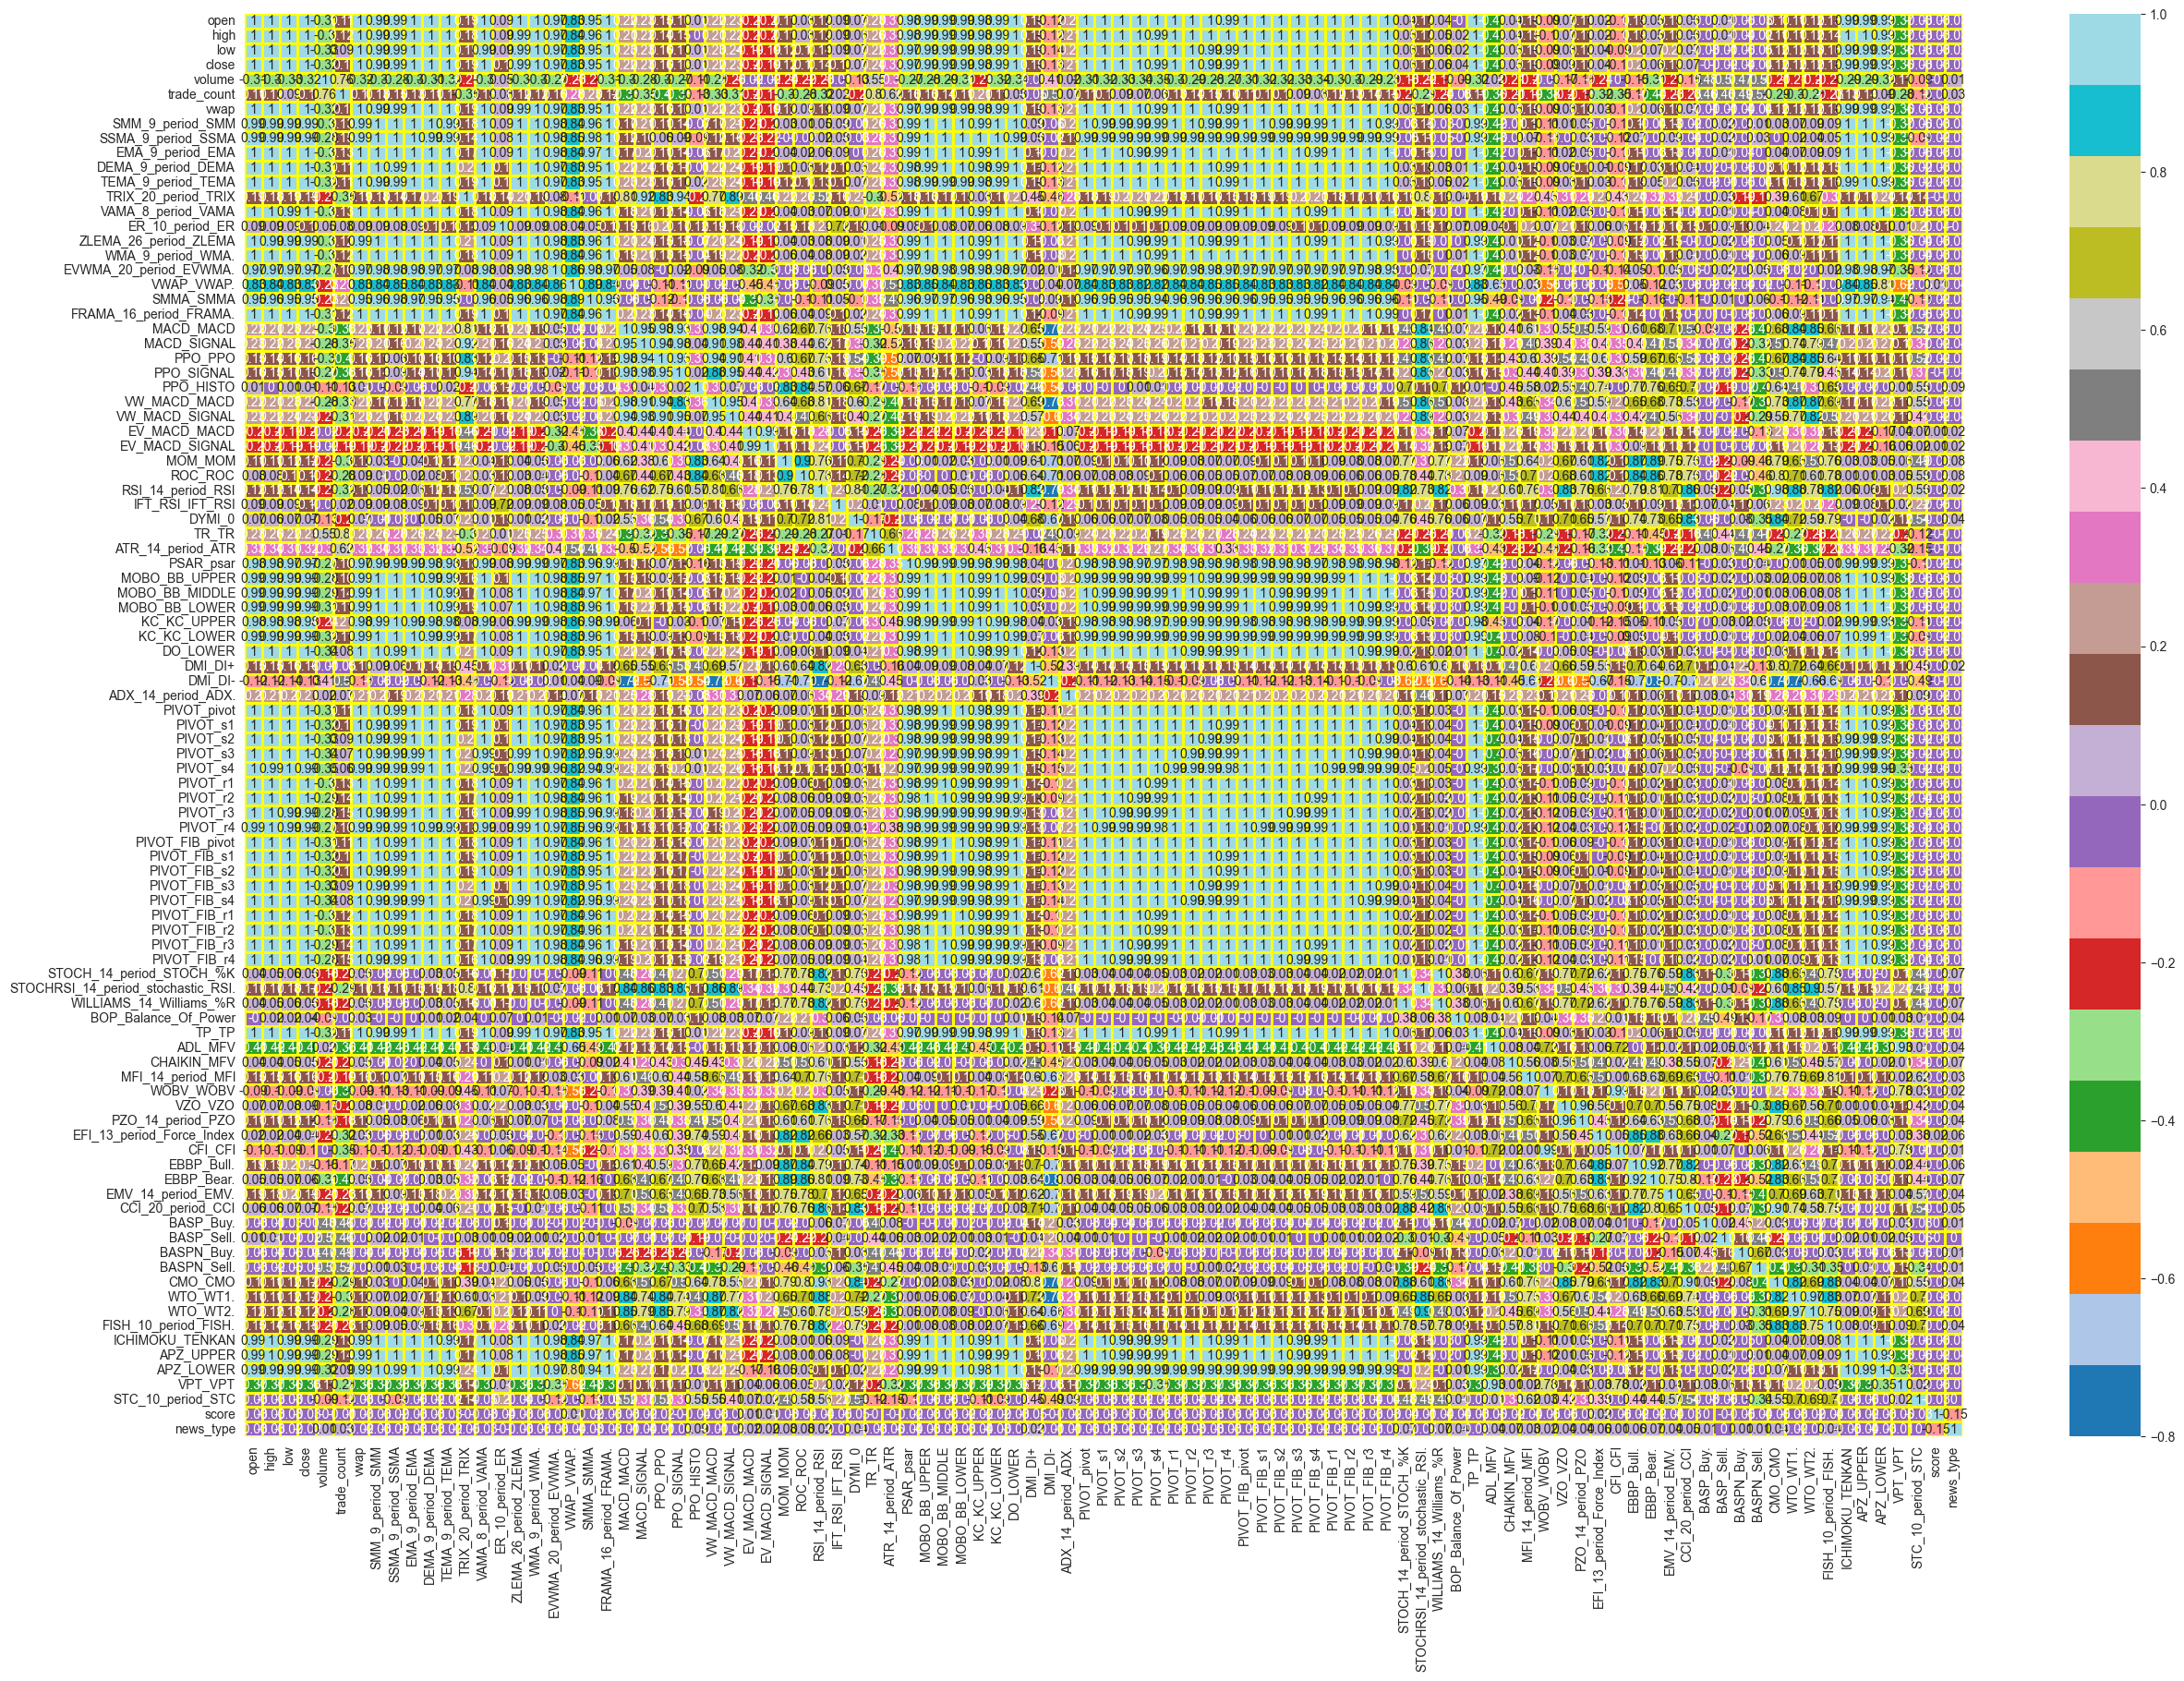

In [70]:
corr =df.corr()
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
sns.heatmap(corr.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [71]:
corr_matrix = pd.DataFrame(corr)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

#### Removing highly correlated features, the 'close' price is the target feature

In [72]:
low_corr_columns = ['close', 'vwap', 'volume', 'trade_count', 'TRIX_20_period_TRIX', 'ER_10_period_ER', 'PPO_HISTO', 'VW_MACD_MACD', 'MOM_MOM', 'ROC_ROC', 'RSI_14_period_RSI', 'IFT_RSI_IFT_RSI', 'DYMI_0', 'TR_TR', 'BOP_Balance_Of_Power', 'ADL_MFV', 'VZO_VZO', 'EBBP_Bull.', 'EBBP_Bear.', 'BASP_Buy.', 'BASP_Sell.', 'BASPN_Buy.', 'BASPN_Sell.', 'VPT_VPT', 'score', 'news_type']

In [73]:
df_corr  = df[low_corr_columns]

<Axes: >

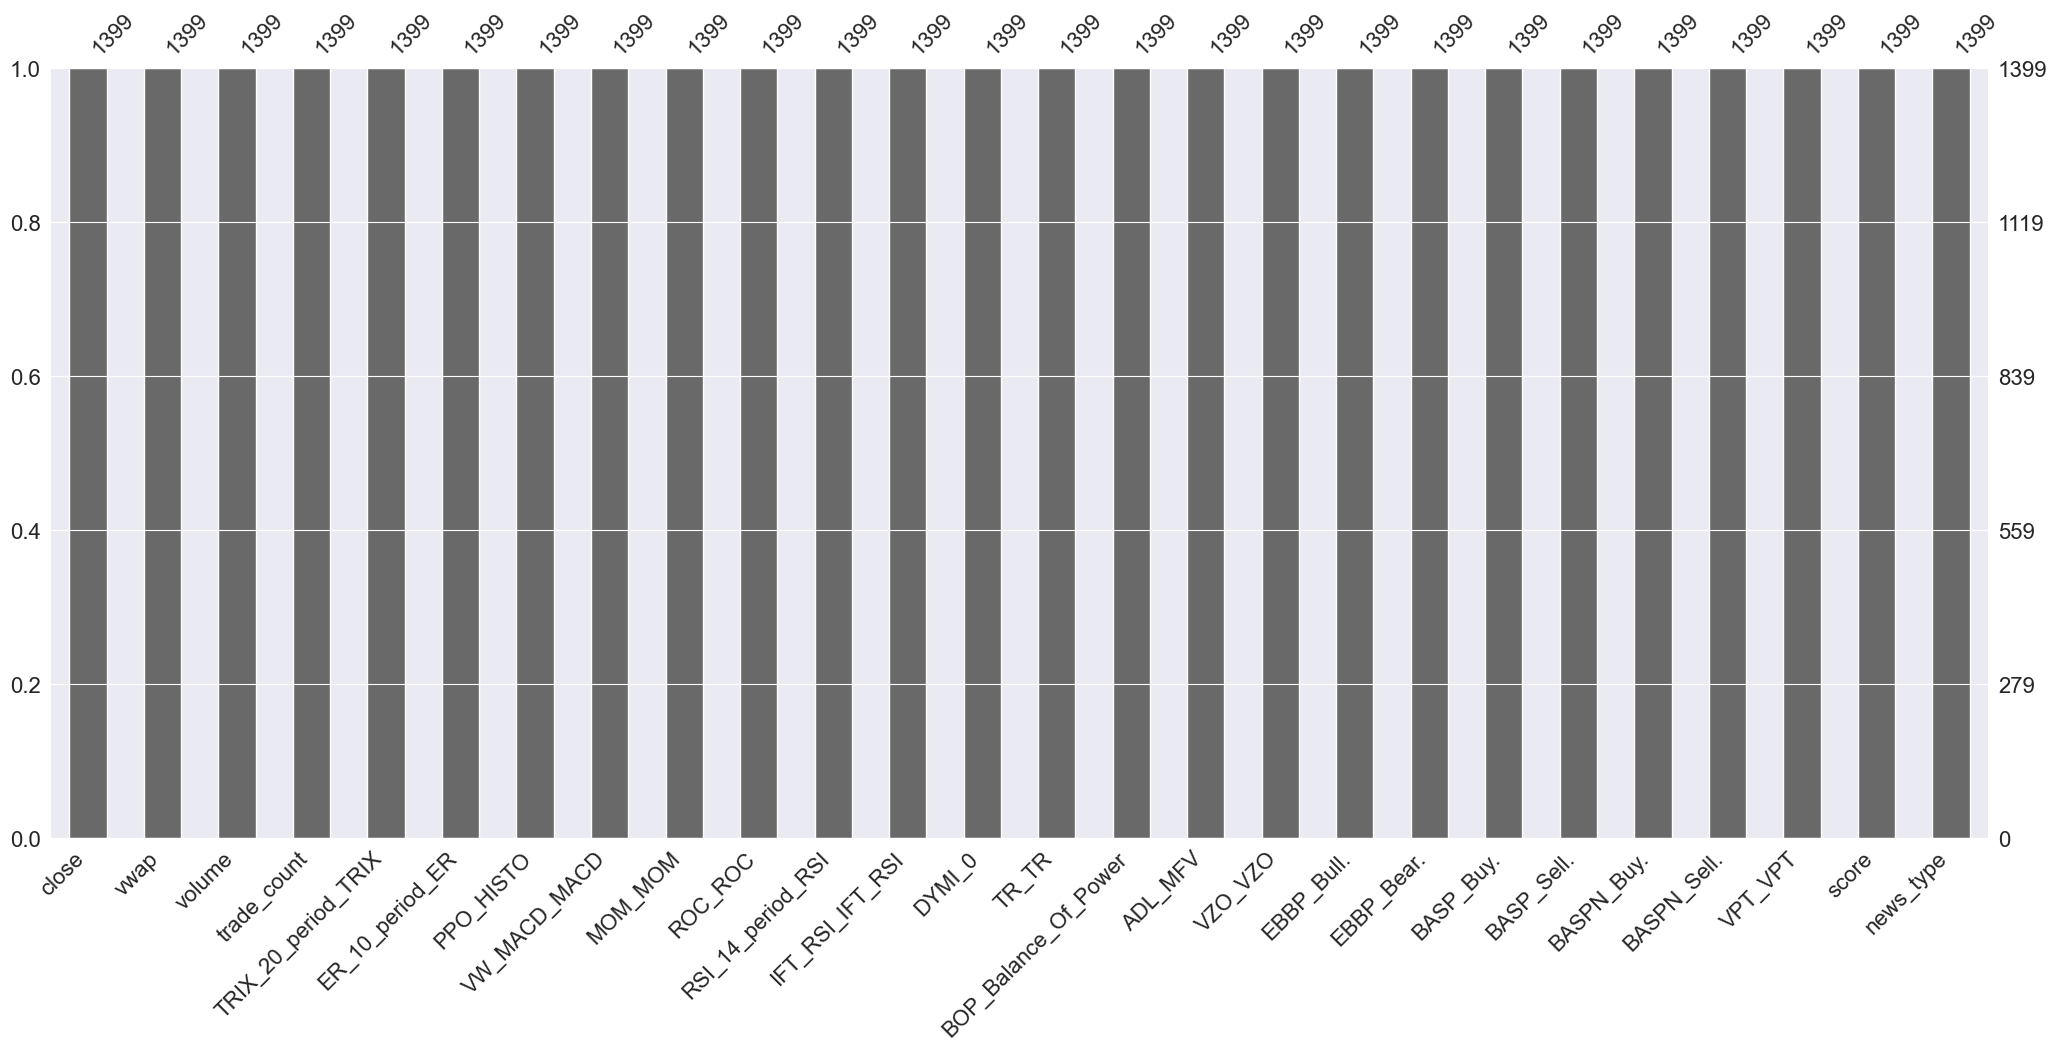

In [74]:
msno.bar(df_corr)

In [75]:
df_corr.head()

close       vwap      volume  trade_count  TRIX_20_period_TRIX  \
2016-01-25  55.66  56.137613  22118832.0     139637.0            -0.361674   
2016-01-26  57.08  56.810083  19392731.0     107516.0            -0.357426   
2016-01-28  57.28  57.280159  16677125.0     109380.0            -0.339606   
2016-02-01  58.86  58.885386  17857599.0     113520.0            -0.302403   
2016-02-02  57.03  57.134165  24152125.0     137045.0            -0.285002   

            ER_10_period_ER  PPO_HISTO  VW_MACD_MACD  MOM_MOM    ROC_ROC  ...  \
2016-01-25         0.377315  -0.255183     -0.632199    -3.26 -11.383538  ...   
2016-01-26         0.175527  -0.108513     -0.583954    -1.75  -5.292849  ...   
2016-01-28         0.007059   0.086908     -0.492193    -0.06  -2.634710  ...   
2016-02-01         0.194861   0.438624     -0.152994     1.82   2.650855  ...   
2016-02-02         0.001795   0.310414     -0.185819     0.02  -2.010309  ...   

              VZO_VZO  EBBP_Bull.  EBBP_Bear.  BASP_Buy.  BASP_Sell.  \
2016-01-25 -49.498185   -0.408985   -1.658985   0.087404    0.950238   
2016-01-26 -33.854795   -0.081043   -1.421043   1.486910    0.054953   
2016-01-28 -28.099366    0.756447   -0.583553   0.694935    0.485192   
2016-02-01 -15.057831    1.896527    0.686527   0.421281    0.651507   
2016-02-02 -26.616659    0.334106   -0.895894   0.399669    1.054106   

            BASPN_Buy.  BASPN_Sell.       VPT_VPT     score  news_type  
2016-01-25    1.008164     1.079303 -1.721438e+08  0.966308          1  
2016-01-26    1.065274     0.957108 -1.365423e+08  0.928192          0  
2016-01-28    0.979550     0.913249 -1.440198e+08  0.999341          1  
2016-02-01    1.160532     0.799219 -1.006070e+08  0.819788          1  
2016-02-02    1.077978     0.826874 -1.339880e+08  0.997212          0  

[5 rows x 26 columns]

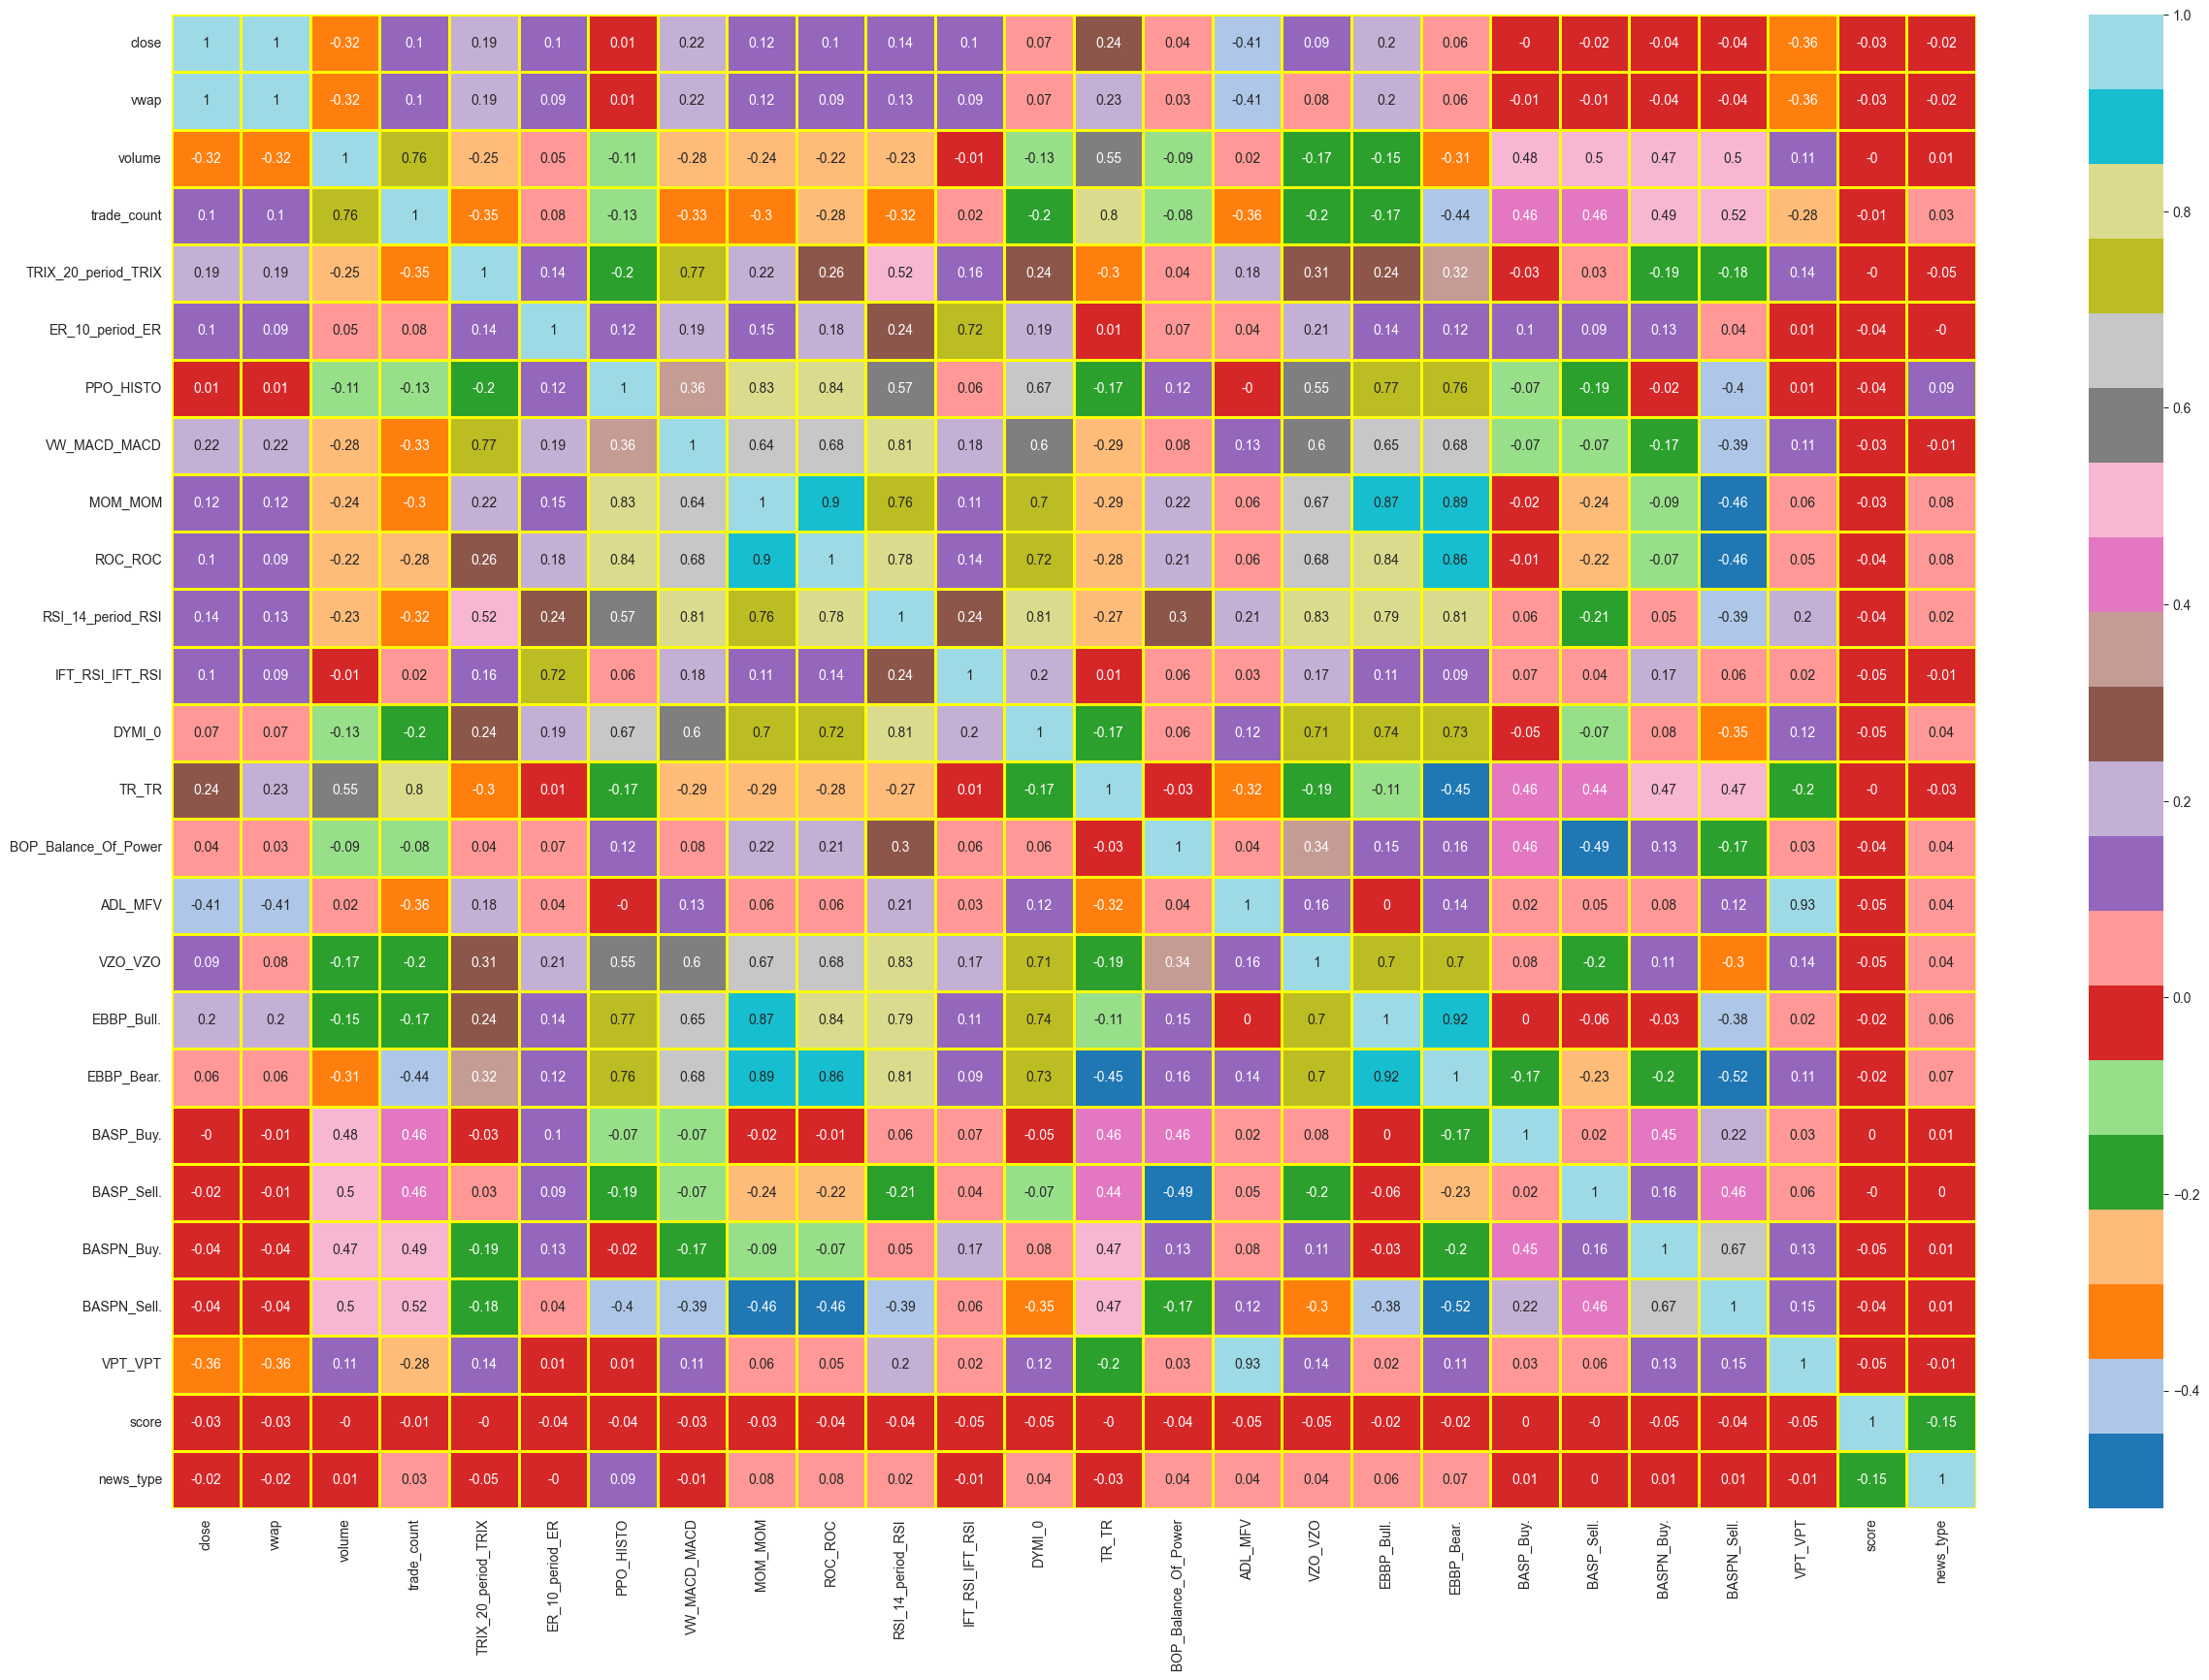

In [76]:
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
corr_low =df_corr.corr()
sns.heatmap(corr_low.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [77]:
# Correlations to the Target feature 'close'
corr_matrix = pd.DataFrame(corr_low)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

In [78]:
df_corr.describe()

close         vwap        volume    trade_count  \
count  1399.000000  1399.000000  1.399000e+03    1399.000000   
mean    118.881237   118.880825  1.583948e+07  119827.245890   
std      29.327735    29.320290  7.818385e+06   55583.411866   
min      53.070000    53.284123  1.604000e+05       1.000000   
25%      98.245000    98.494076  1.082127e+07   83741.500000   
50%     115.850000   116.111837  1.414673e+07  107609.000000   
75%     141.920000   142.082344  1.817264e+07  138244.000000   
max     176.270000   175.830884  7.290765e+07  457367.000000   

       TRIX_20_period_TRIX  ER_10_period_ER    PPO_HISTO  VW_MACD_MACD  \
count          1399.000000      1399.000000  1399.000000   1399.000000   
mean              0.042221         0.343729     0.011610      0.495694   
std               0.222005         0.236013     0.572201      1.981214   
min              -1.037542         0.000376    -3.149239     -6.928656   
25%              -0.077172         0.145349    -0.298048     -0.702054   
50%               0.062955         0.311667     0.007038      0.597857   
75%               0.172432         0.509290     0.320007      1.700220   
max               0.531040         1.000000     2.693997      5.740988   

           MOM_MOM      ROC_ROC  ...      VZO_VZO   EBBP_Bull.   EBBP_Bear.  \
count  1399.000000  1399.000000  ...  1399.000000  1399.000000  1399.000000   
mean      0.609492     0.808974  ...     0.791622     1.476970    -0.826833   
std       6.455875     5.796433  ...    29.061679     3.090711     3.468892   
min     -38.720000   -32.038694  ...   -74.469169   -18.529212   -24.759412   
25%      -2.290000    -2.184760  ...   -19.588182    -0.063115    -2.178352   
50%       0.880000     1.054111  ...    -0.051686     1.411969    -0.403113   
75%       4.180000     4.096501  ...    21.534548     3.057708     1.166146   
max      23.980000    24.219862  ...    83.096700    15.584545    10.213254   

         BASP_Buy.   BASP_Sell.   BASPN_Buy.  BASPN_Sell.       VPT_VPT  \
count  1399.000000  1399.000000  1399.000000  1399.000000  1.399000e+03   
mean      1.088034     1.136833     1.064556     1.083228  2.071455e+08   
std       1.231428     1.365621     0.355301     0.397929  3.726057e+08   
min       0.000000     0.000000     0.495873     0.487405 -3.914145e+08   
25%       0.389422     0.349940     0.864598     0.836577 -1.097987e+08   
50%       0.754974     0.719202     0.991621     0.988993  1.140565e+08   
75%       1.367907     1.396565     1.169633     1.229134  5.816725e+08   
max      11.932866    13.974026     3.520925     3.671142  9.704963e+08   

             score    news_type  
count  1399.000000  1399.000000  
mean      0.928611     0.572552  
std       0.108196     0.494885  
min       0.502791     0.000000  
25%       0.913440     0.000000  
50%       0.976181     1.000000  
75%       0.993851     1.000000  
max       0.999861     1.000000  

[8 rows x 26 columns]

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'vwap'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'trade_count'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'ER_10_period_ER'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'VW_MACD_MACD'}>,
        <Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'DYMI_0'}>,
        <Axes: title={'center': 'TR_TR'}>,
        <Axes: title={'center': 'BOP_Balance_Of_Power'}>],
       [<Axes: title={'center': 'ADL_MFV'}>,
        <Axes: title={'center': 'VZO_VZO'}>,
        <Axes: title={'center': 'EBBP_Bull.'}>,
        <Axes: title={'center': 'EBBP_Bear.'}>,
        <Axes: title={'center': 'BASP_Buy.'}>],
       [<Axes: title={'center': 'BA

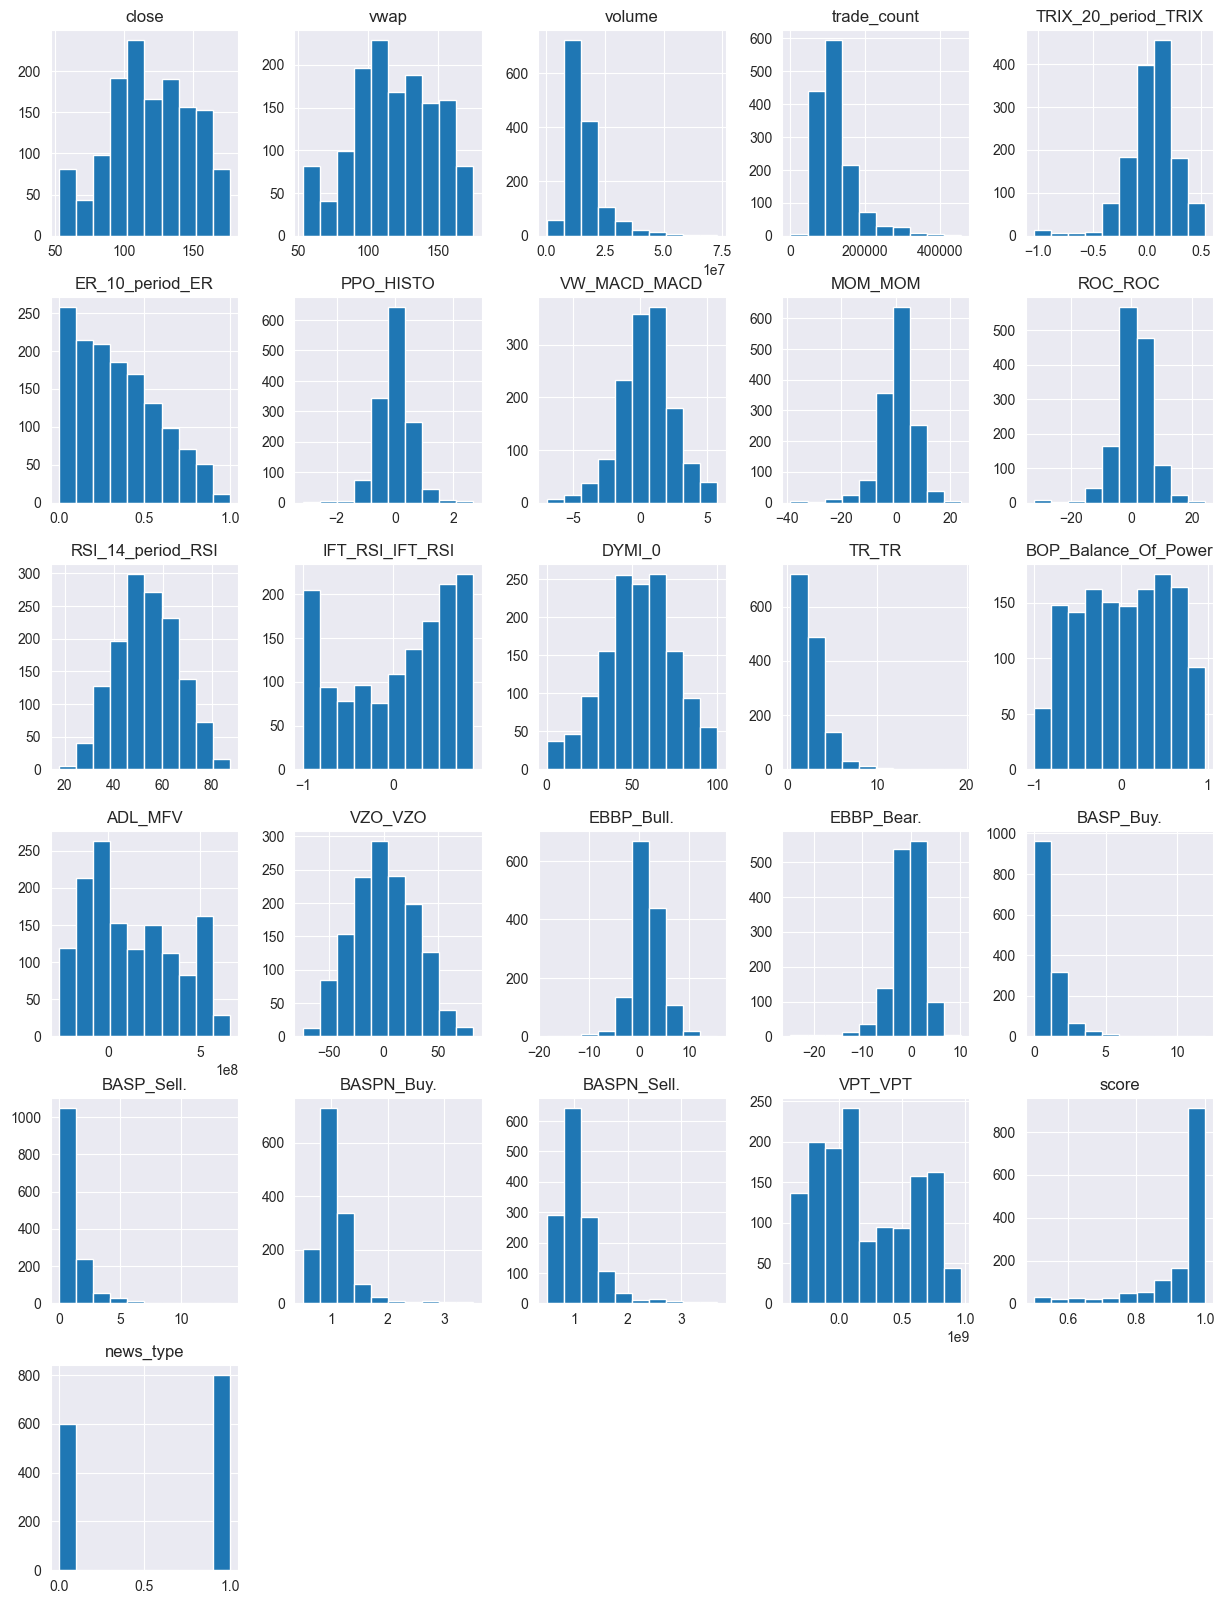

In [79]:
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_corr.hist(ax=ax)

##### from the dataframe describe mean and std are not 0 and 1, and from the histogram we can see the dataset is skewed on left and right
##### even the 'vwap' feature is highly correlated to the target, it is kept. The "Volume Weighted Average Price" is a benchmark indicator for traders

In [80]:
# Normalization of the dataset
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
trans_array = trans.fit_transform(df_corr)
df_norm = pd.DataFrame(trans_array)
named_columns = df_corr.columns
numer_columns = df_norm.copy().columns
tuples = [(key, value) for i, (key, value) in enumerate(zip(numer_columns, named_columns))]
columns = dict(tuples)
df_norm.rename(columns=columns, inplace=True)
df_norm = df_norm[named_columns]
df_norm.index = df.index
df_norm.describe()

close         vwap       volume  trade_count  \
count  1399.000000  1399.000000  1399.000000  1399.000000   
mean      0.000065     0.000128    -0.000018    -0.000320   
std       1.014198     1.014270     1.014108     1.015306   
min      -5.199338    -5.199338    -5.199338    -5.199338   
25%      -0.674879    -0.674675    -0.674344    -0.674735   
50%       0.000418     0.000346     0.000829    -0.000193   
75%       0.674460     0.674142     0.674136     0.674855   
max       5.199338     5.199338     5.199338     5.199338   

       TRIX_20_period_TRIX  ER_10_period_ER    PPO_HISTO  VW_MACD_MACD  \
count          1399.000000      1399.000000  1399.000000   1399.000000   
mean              0.000031         0.000008     0.000012      0.000129   
std               1.014981         1.014101     1.014211      1.014645   
min              -5.199338        -5.199338    -5.199338     -5.199338   
25%              -0.674538        -0.673702    -0.674472     -0.674590   
50%               0.001015        -0.000123    -0.000179     -0.000481   
75%               0.674204         0.674290     0.673897      0.673530   
max               5.199338         5.199338     5.199338      5.199338   

           MOM_MOM      ROC_ROC  ...      VZO_VZO   EBBP_Bull.   EBBP_Bear.  \
count  1399.000000  1399.000000  ...  1399.000000  1399.000000  1399.000000   
mean      0.000046    -0.000008  ...    -0.000012     0.000020     0.000025   
std       1.014194     1.014044  ...     1.014577     1.013719     1.013995   
min      -5.199338    -5.199338  ...    -5.199338    -5.199338    -5.199338   
25%      -0.674973    -0.673790  ...    -0.674820    -0.673880    -0.674232   
50%       0.000000     0.000790  ...     0.000489     0.000387    -0.000372   
75%       0.673702     0.673792  ...     0.674173     0.673766     0.674119   
max       5.199338     5.199338  ...     5.199338     5.199338     5.199338   

         BASP_Buy.   BASP_Sell.   BASPN_Buy.  BASPN_Sell.      VPT_VPT  \
count  1399.000000  1399.000000  1399.000000  1399.000000  1399.000000   
mean     -0.017753    -0.017746     0.000011     0.000018     0.000020   
std       1.081054     1.081209     1.014294     1.014314     1.013954   
min      -5.199338    -5.199338    -5.199338    -5.199338    -5.199338   
25%      -0.674286    -0.673942    -0.674057    -0.674374    -0.674471   
50%       0.000282     0.001040     0.000668     0.000161     0.000853   
75%       0.674105     0.673769     0.674425     0.674666     0.674268   
max       5.199338     5.199338     5.199338     5.199338     5.199338   

             score    news_type  
count  1399.000000  1399.000000  
mean     -0.000207     0.754443  
std       1.015226     5.146150  
min      -5.199338    -5.199338  
25%      -0.674348    -5.199338  
50%       0.000493     5.199338  
75%       0.674376     5.199338  
max       5.199338     5.199338  

[8 rows x 26 columns]

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'vwap'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'trade_count'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'ER_10_period_ER'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'VW_MACD_MACD'}>,
        <Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'DYMI_0'}>,
        <Axes: title={'center': 'TR_TR'}>,
        <Axes: title={'center': 'BOP_Balance_Of_Power'}>],
       [<Axes: title={'center': 'ADL_MFV'}>,
        <Axes: title={'center': 'VZO_VZO'}>,
        <Axes: title={'center': 'EBBP_Bull.'}>,
        <Axes: title={'center': 'EBBP_Bear.'}>,
        <Axes: title={'center': 'BASP_Buy.'}>],
       [<Axes: title={'center': 'BA

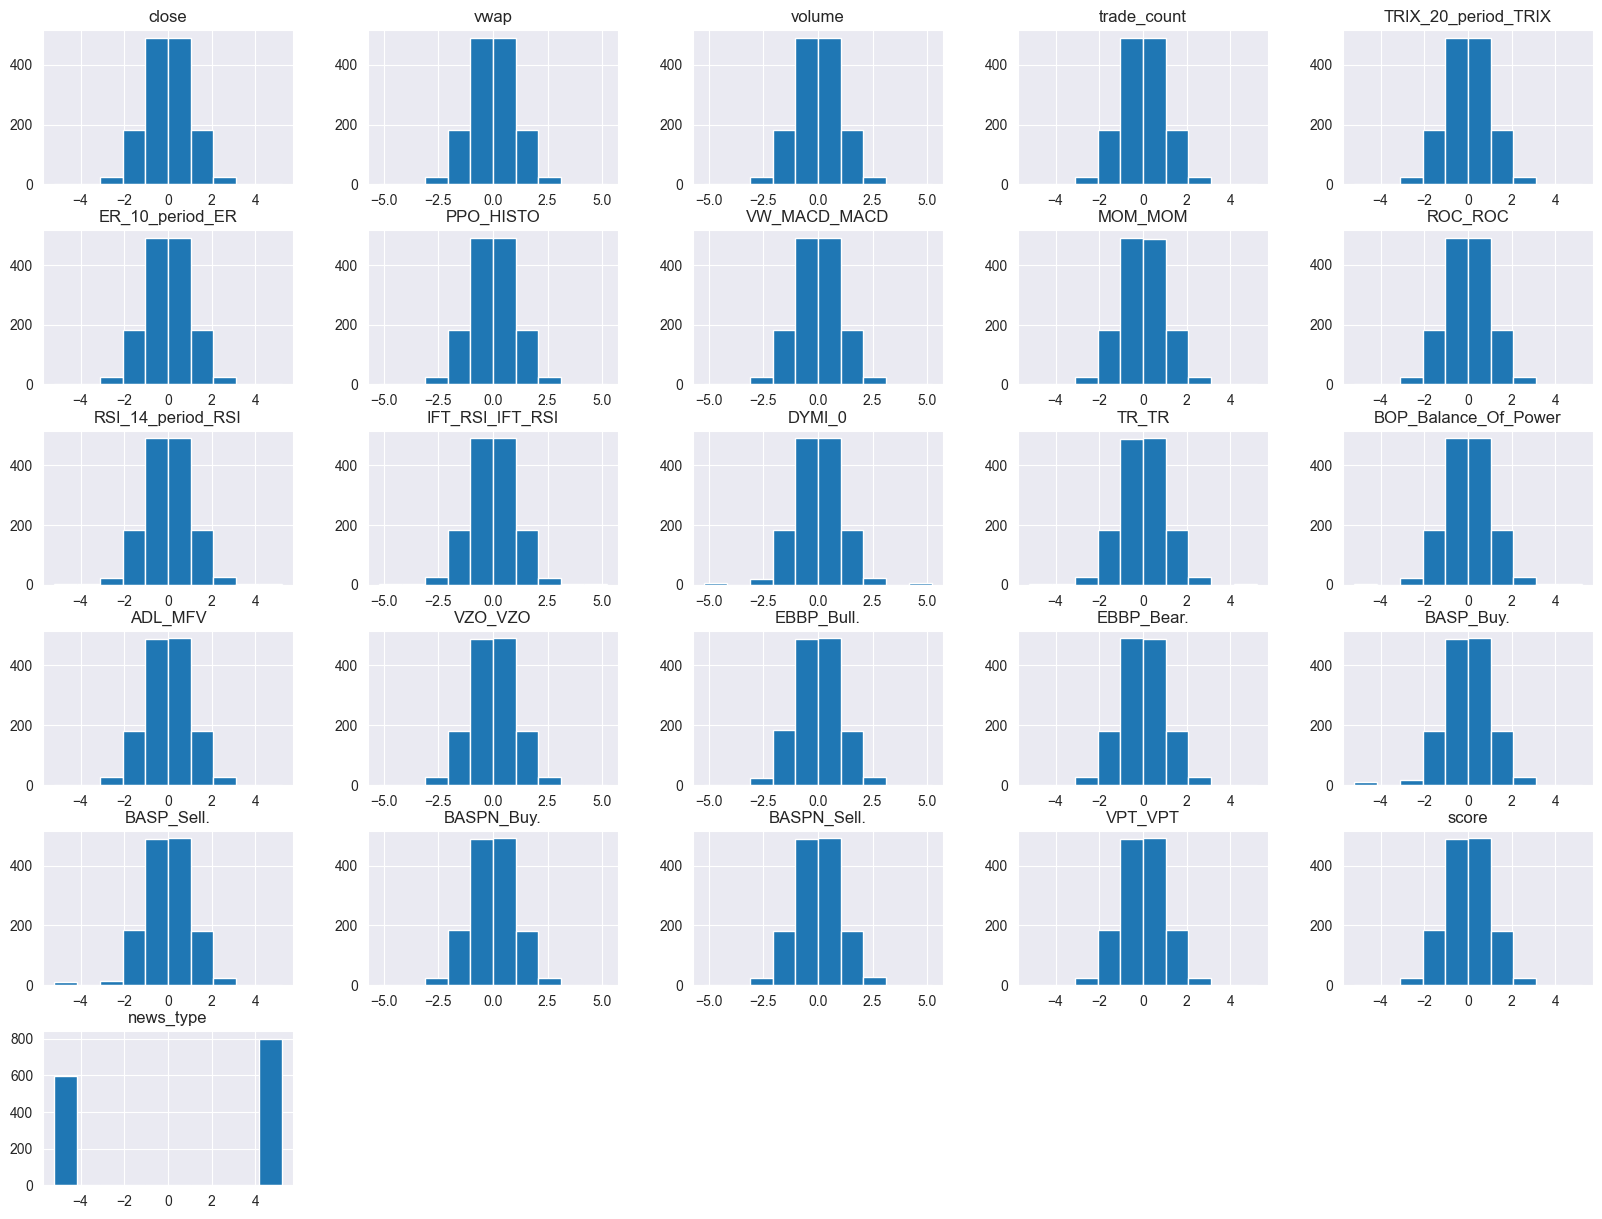

In [81]:
df_norm.hist(figsize=(20,15))

##### As we can see from the describe method of pandas DataFrame, the mean is 0 and std is 1 and from the above bell shape plots, now our dataset has a normal distribution

In [82]:
df_norm.head()

close      vwap    volume  trade_count  TRIX_20_period_TRIX  \
2016-01-25 -3.110234 -2.826878  1.087428     0.715882            -1.884335   
2016-01-26 -2.502524 -2.505502  0.807515    -0.003466            -1.849452   
2016-01-28 -2.438924 -2.419997  0.449893     0.051667            -1.761144   
2016-02-01 -2.138772 -2.115529  0.624185     0.165095            -1.640759   
2016-02-02 -2.541125 -2.445032  1.230634     0.653662            -1.584101   

            ER_10_period_ER  PPO_HISTO  VW_MACD_MACD   MOM_MOM   ROC_ROC  ...  \
2016-01-25         0.224825  -0.577706     -0.638306 -0.848805 -1.942916  ...   
2016-01-26        -0.540530  -0.237802     -0.611782 -0.554263 -1.220766  ...   
2016-01-28        -2.325835   0.156559     -0.557226 -0.194422 -0.762371  ...   
2016-02-01        -0.444537   0.869249     -0.385140  0.213636  0.403351  ...   
2016-02-02        -2.869796   0.657576     -0.404976 -0.182095 -0.637012  ...   

             VZO_VZO  EBBP_Bull.  EBBP_Bear.  BASP_Buy.  BASP_Sell.  \
2016-01-25 -1.764982   -0.783028   -0.468408  -1.686705    0.276608   
2016-01-26 -1.170468   -0.680112   -0.388236   0.787906   -1.789685   
2016-01-28 -0.945928   -0.291119   -0.053926  -0.106202   -0.397479   
2016-02-01 -0.506414    0.221893    0.477051  -0.596482   -0.101299   
2016-02-02 -0.900726   -0.494337   -0.203145  -0.648875    0.384193   

            BASPN_Buy.  BASPN_Sell.   VPT_VPT     score  news_type  
2016-01-25    0.091563     0.309270 -0.880911 -0.172259   5.199338  
2016-01-26    0.296606    -0.129492 -0.774942 -0.588165  -5.199338  
2016-01-28   -0.052438    -0.325715 -0.795656  1.749908   5.199338  
2016-02-01    0.650211    -0.860019 -0.639820 -1.160155   5.199338  
2016-02-02    0.358415    -0.719000 -0.763912  1.023003  -5.199338  

[5 rows x 26 columns]

### Modeling

In [83]:
X = df.drop(columns=['close'], axis=1)
y = df_norm['close']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

X_corr = df_corr.drop(columns=['close'], axis=1)
y_corr = df_corr['close']
X_corr_train, X_corr_val, y_corr_train, y_corr_val = train_test_split(X_corr, y_corr, test_size=0.33, random_state=42)

X_norm = df_norm.drop(columns=['close'], axis=1)
y_norm = df_norm['close']
X_norm_train, X_norm_val, y_norm_train, y_norm_val = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)

In [84]:
X_val.sort_index(inplace=True)
X_train.sort_index(inplace=True)
X_corr_val.sort_index(inplace=True)
X_corr_train.sort_index(inplace=True)
X_norm_val.sort_index(inplace=True)
X_norm_train.sort_index(inplace=True)

In [85]:
y_val.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_corr_val.sort_index(inplace=True)
y_corr_train.sort_index(inplace=True)
y_norm_val.sort_index(inplace=True)
y_norm_train.sort_index(inplace=True)

### Regression  Baseline Model using normalized data

In [86]:
poly_ordinal_ohe_4 = make_column_transformer((PolynomialFeatures(include_bias=False, degree=4), make_column_selector(dtype_include=np.number)))

In [87]:
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge.fit(X_norm_train, y_norm_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FF658CFD30>)])),
                ('scaler', StandardScaler()),
                ('ridgereg', RidgeCV(alphas=[0.001, 0.1, 1.0, 10.0, 100.0]))])

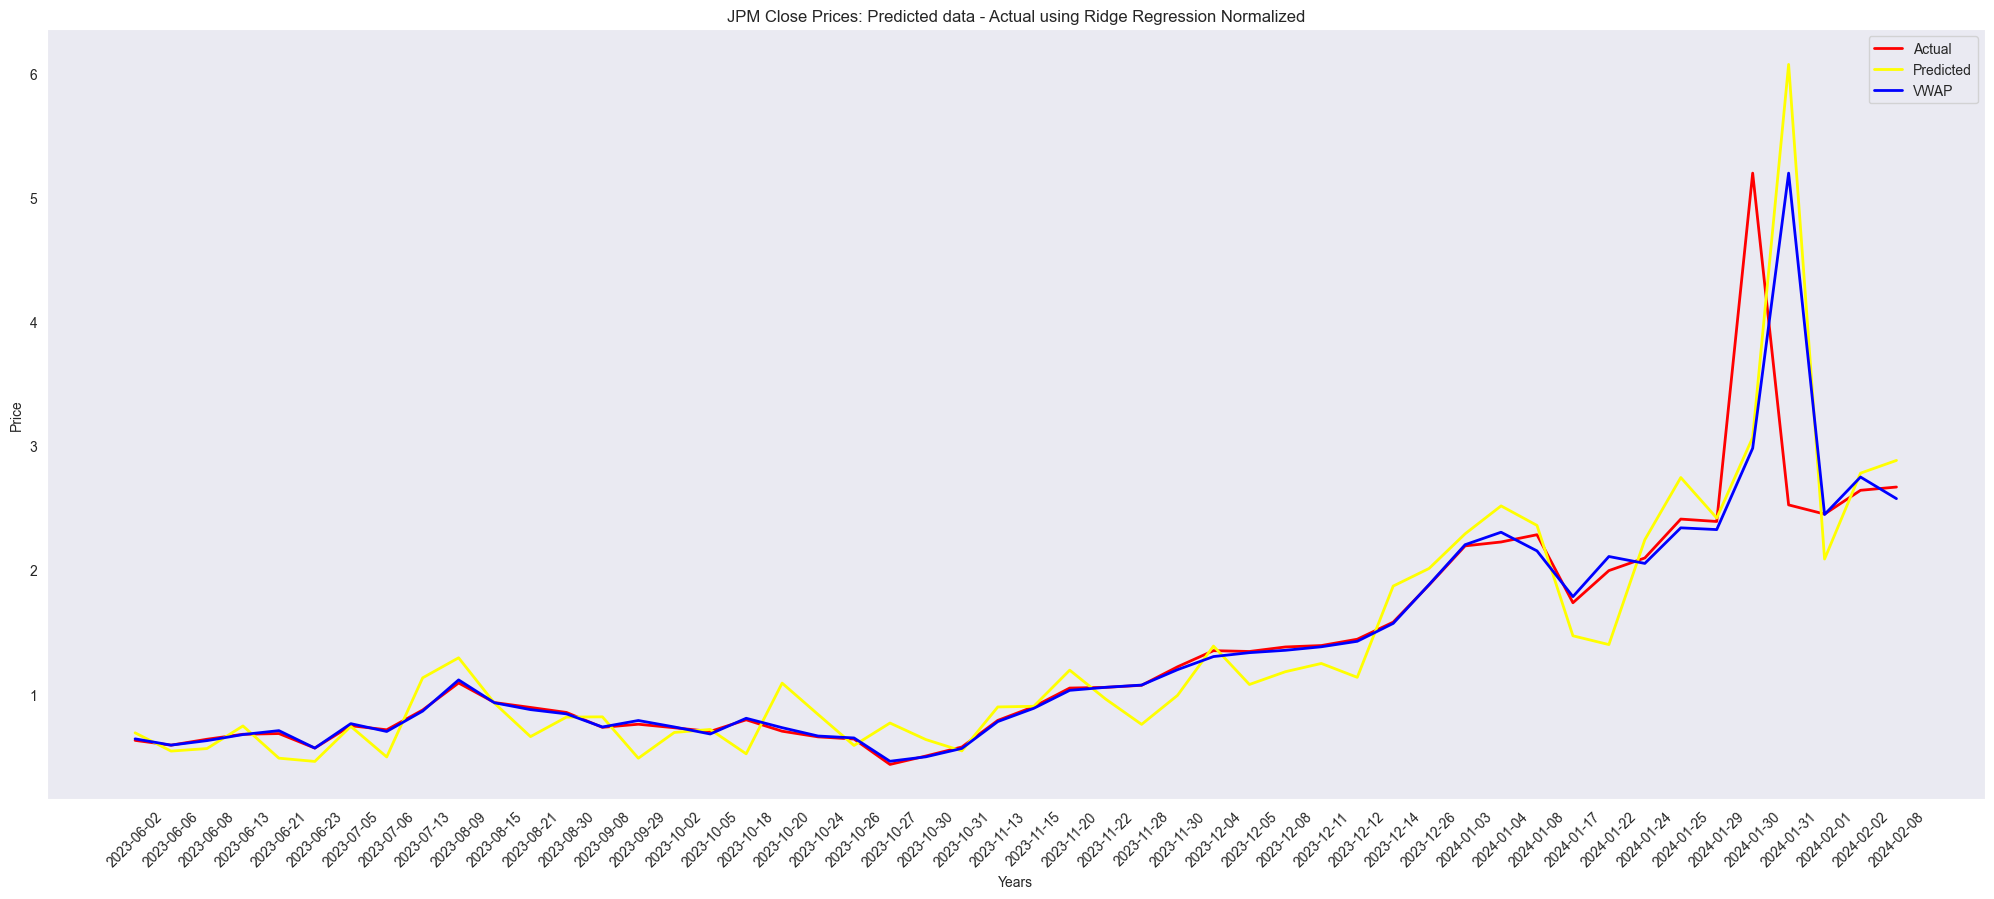

In [88]:
regression_model = {'Ridge Regression Normalized': ridge }
reg_model_metrics(regression_model, X_norm_train, X_norm_val, y_norm_train, y_norm_val)

### Regression Models

In [89]:
linreg = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_corr_train, y_corr_train)

alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge1 = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge1.fit(X_corr_train, y_corr_train)

lasso = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('lasso_reg', Lasso(random_state=42))])
lasso.fit(X_corr_train, y_corr_train)

param_grid = {
    'clf__alpha': [0.1, 1, 10, 0.01],
    'clf__tol': [0.0001, 0.001]
}
pipeline_grid = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', MinMaxScaler()), ('clf', HuberRegressor())])
grid_search = GridSearchCV(pipeline_grid, param_grid, scoring='r2', cv=10, return_train_score=True, n_jobs=-1)
# Fit the GridSearchCV object to the data
grid_search.fit(X_corr_train, y_corr_train)

rfr = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('rfr', RandomForestRegressor(max_depth=2, random_state=0))])
rfr.fit(X_corr_train, y_corr_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FF658CFD30>)])),
                ('scaler', StandardScaler()),
                ('rfr', RandomForestRegressor(max_depth=2, random_state=0))])

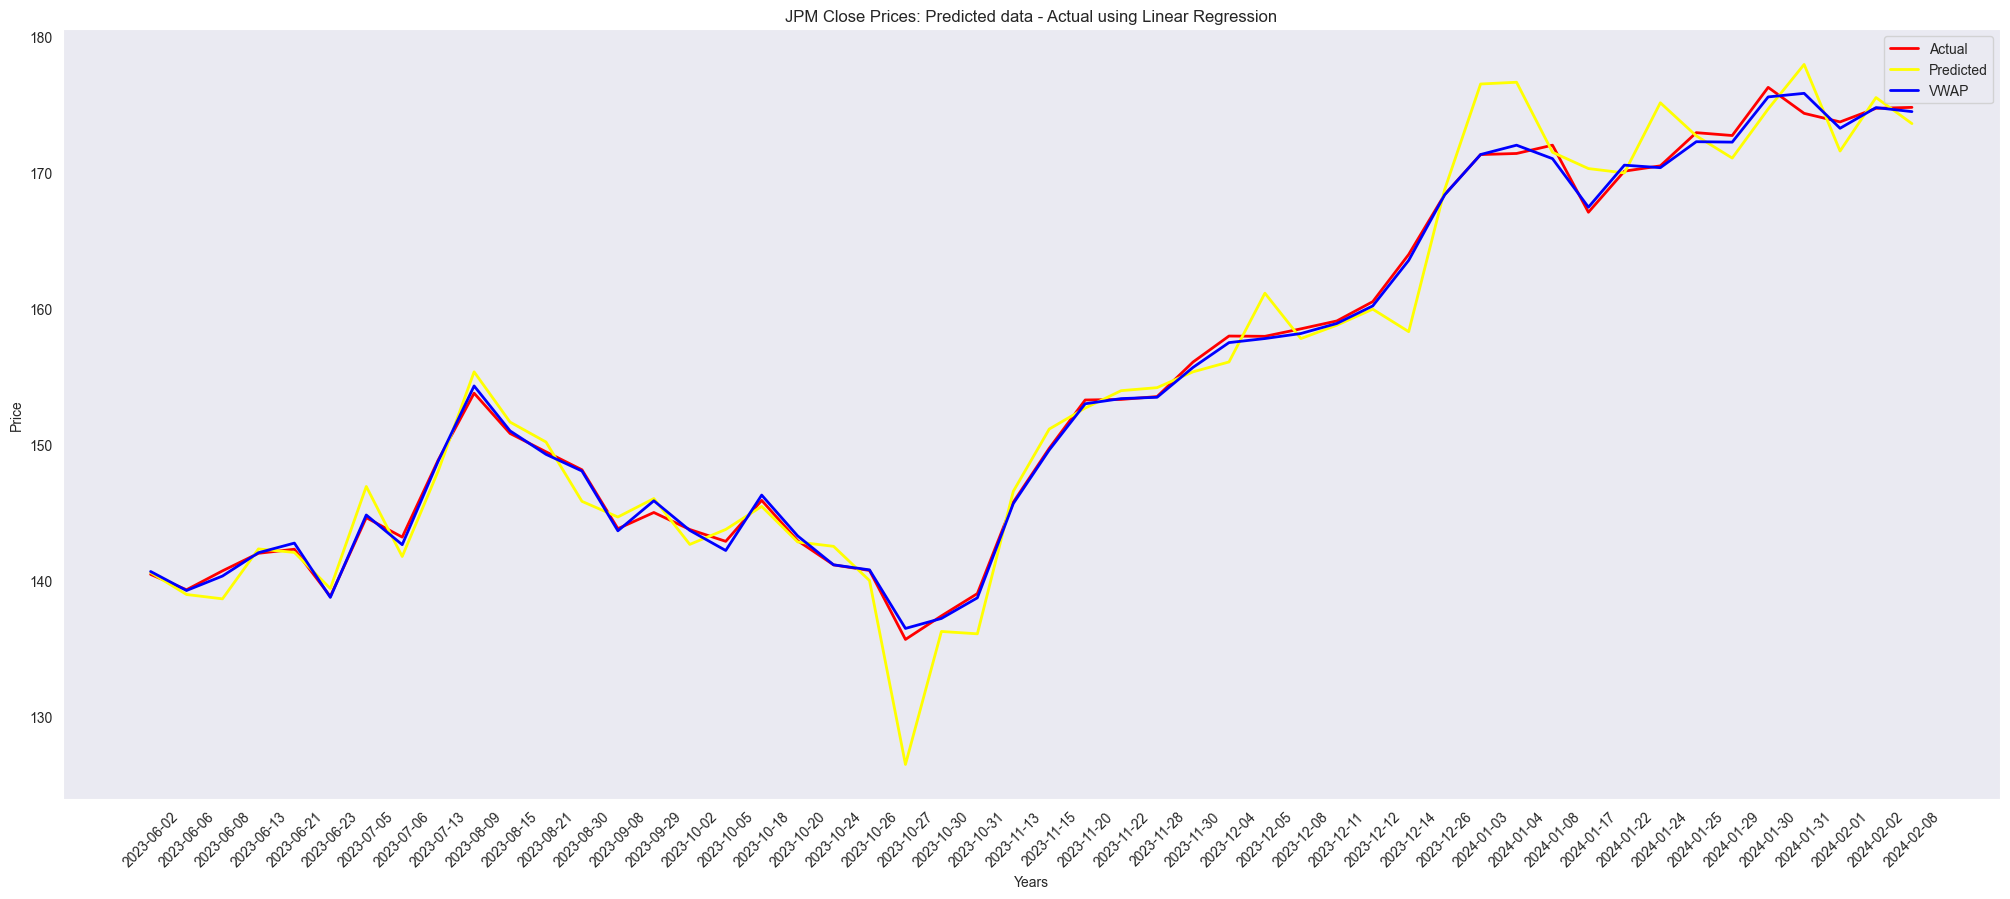

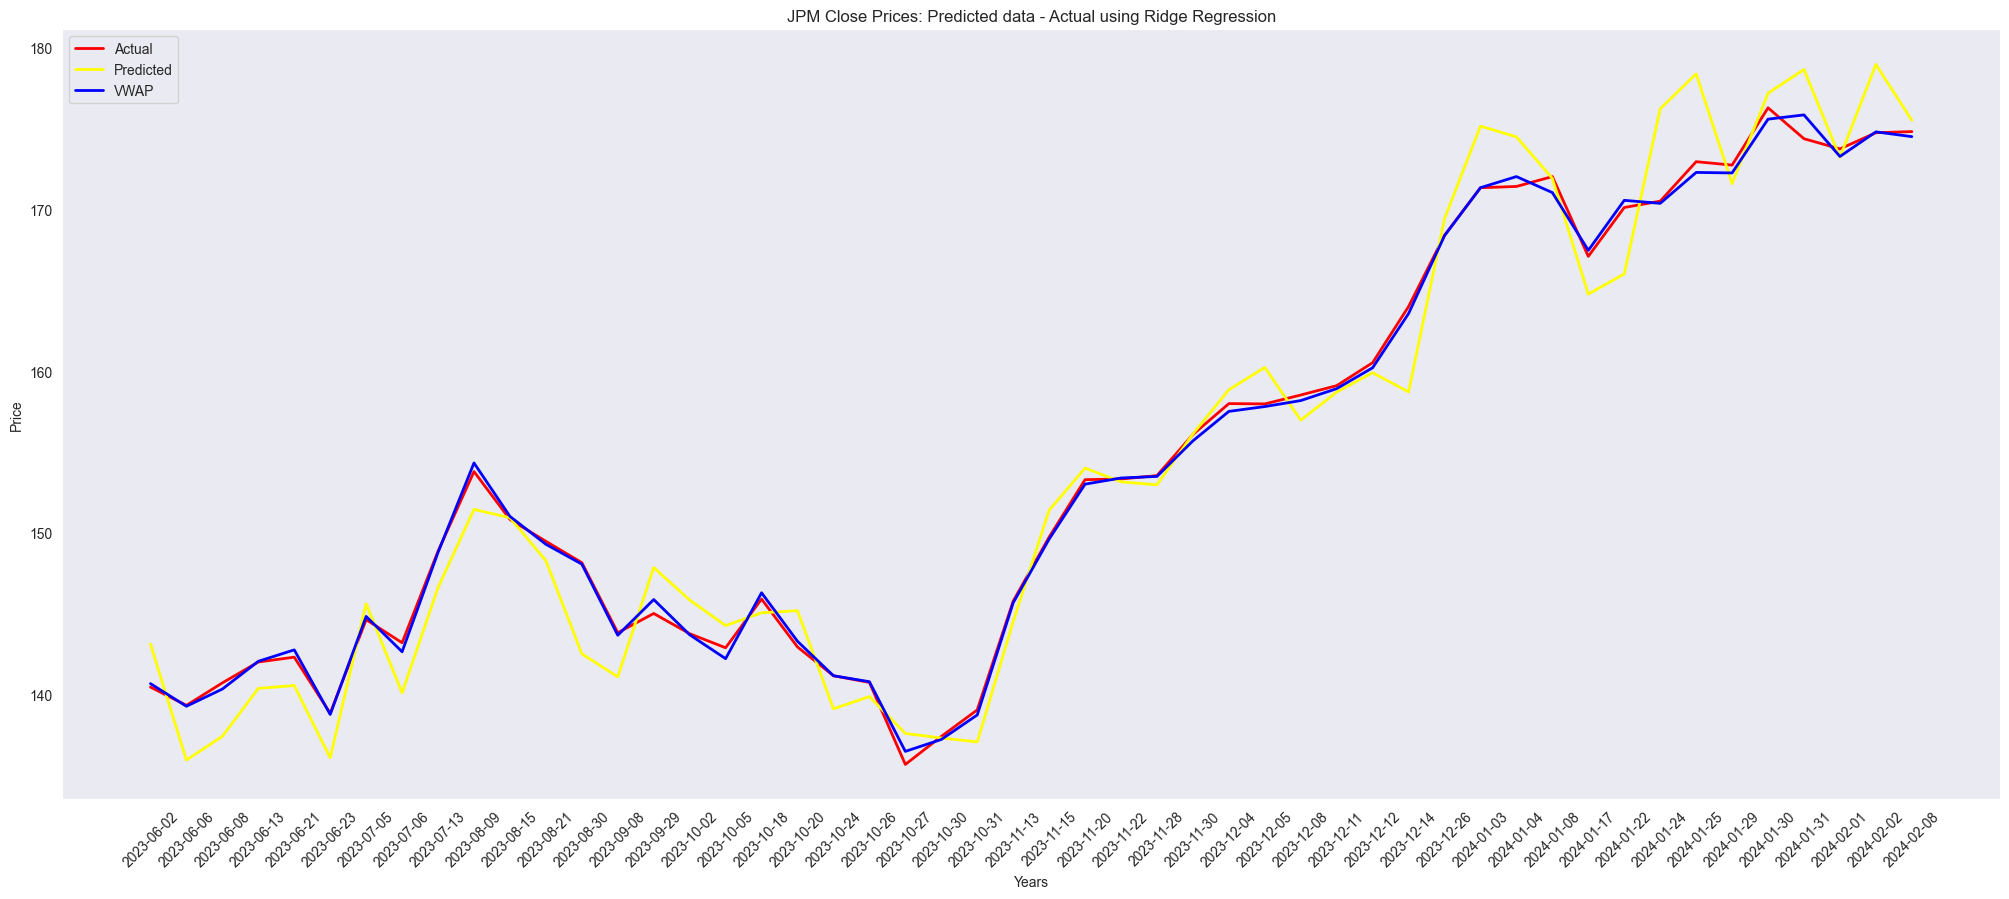

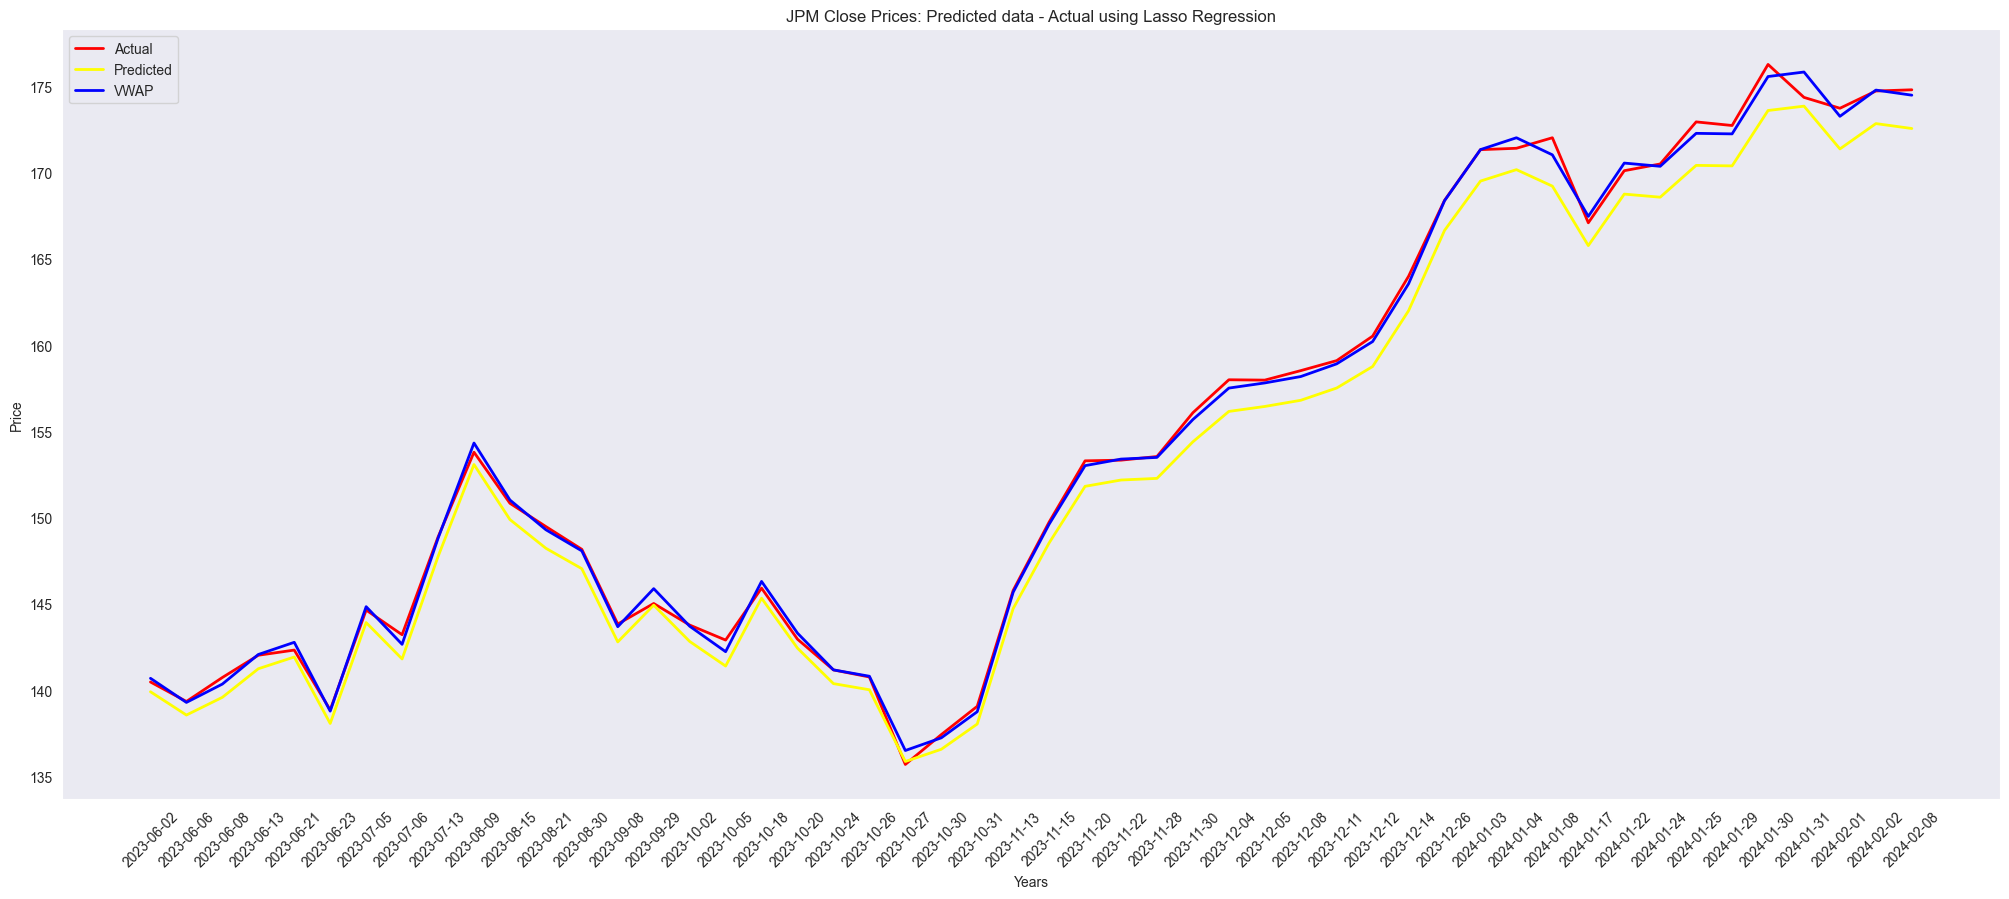

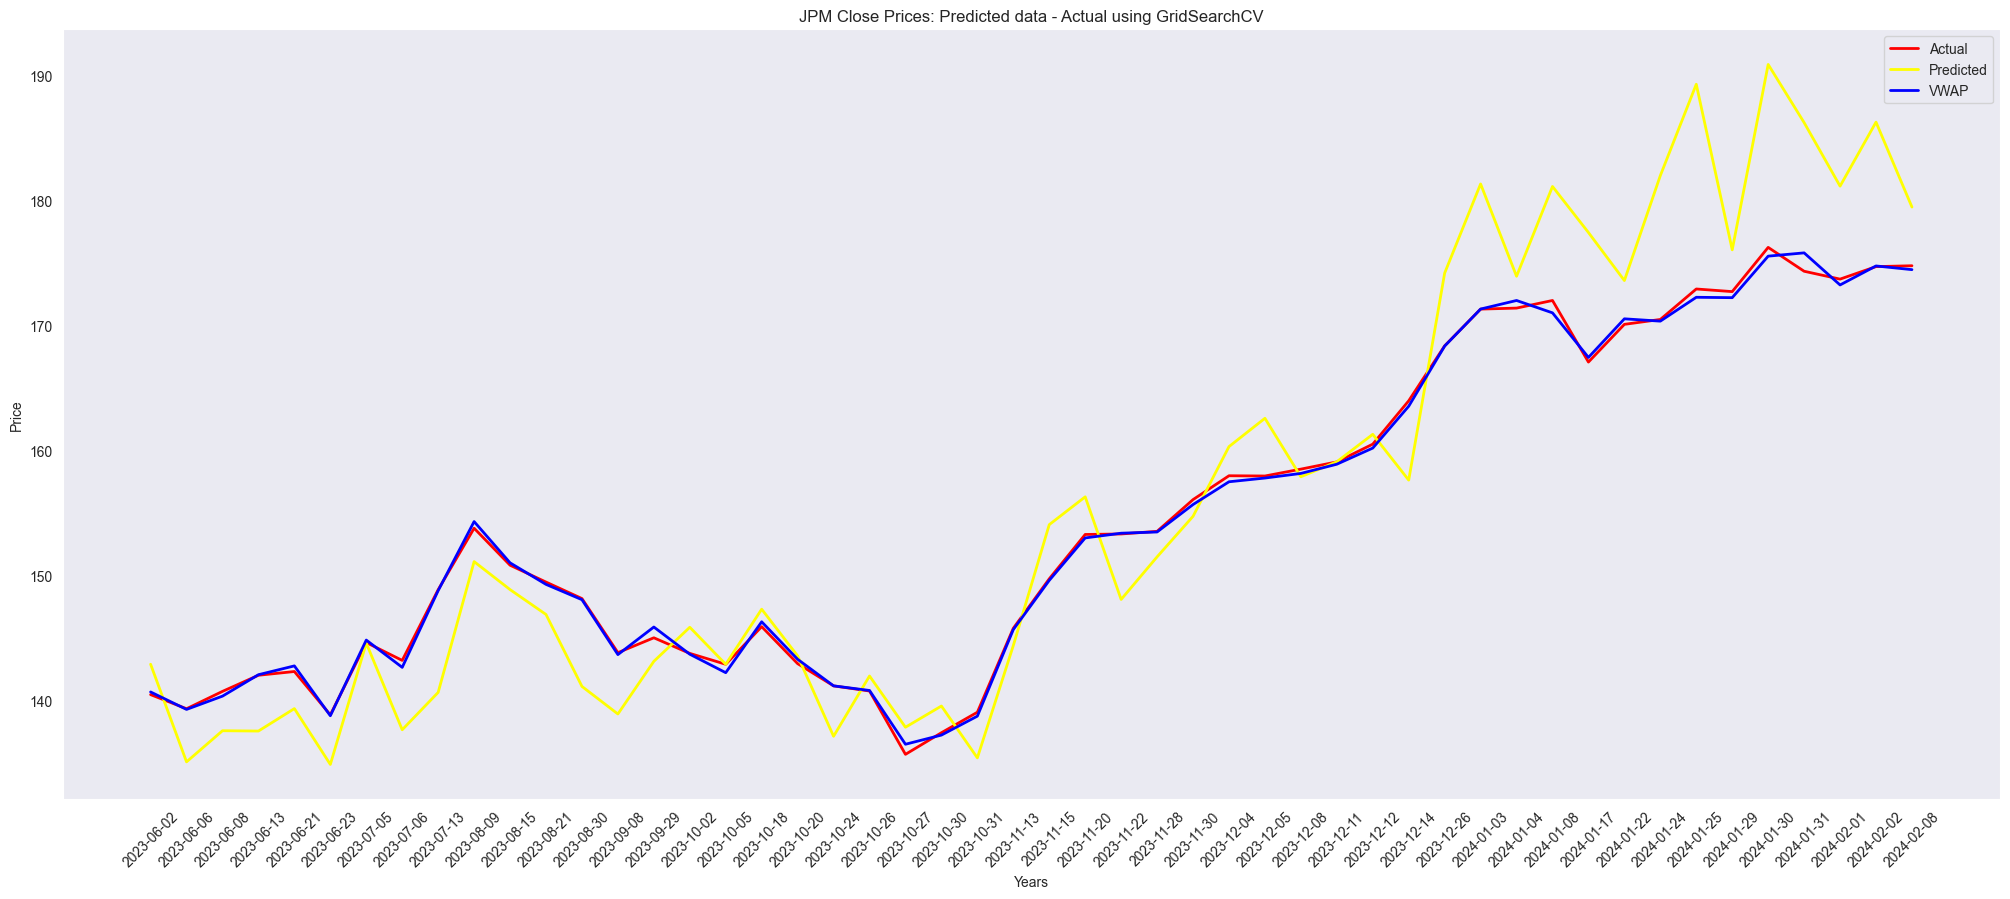

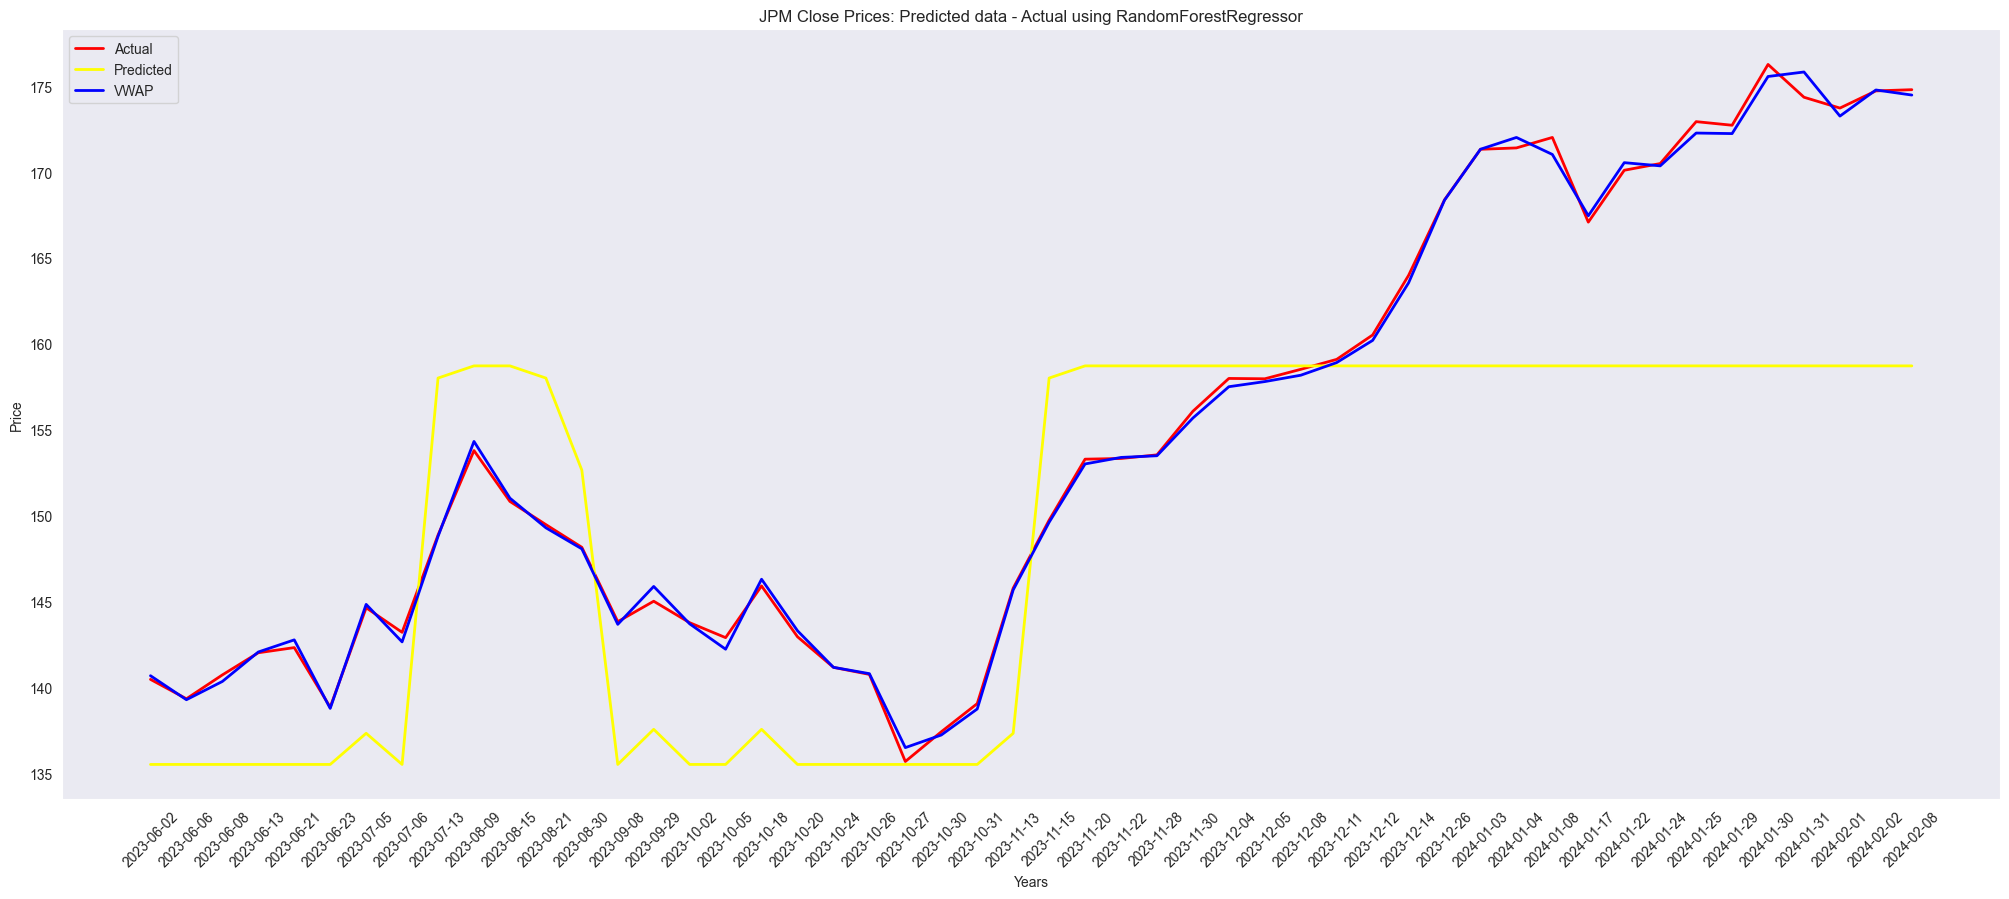

In [90]:
regression_models = {'Linear Regression': linreg,
                     'Ridge Regression': ridge1,
                     'Lasso Regression': lasso,
                     'GridSearchCV': grid_search,
                     'RandomForestRegressor': rfr
                     }
reg_model_metrics(regression_models, X_corr_train, X_corr_val, y_corr_train, y_corr_val)